In [1]:
#!/usr/bin/env python
# coding: utf-8

import sys
sys.path.append('../')
from rdkit import Chem
from rdkit.Chem.QED import qed
from core.evaluation.utils.sascorer import compute_sa_score
from core.datasets.pl_pair_dataset import PocketLigandPairDataset
from tqdm import tqdm
import torch

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

path = './data/crossdocked_v1.1_rmsd1.0_pocket10'
pose_splits = './data/crossdocked_pocket10_pose_split.pt'
dataset = PocketLigandPairDataset(path)
split = torch.load(pose_splits)

train_ids = split['train']

data_stats = []
for i in tqdm(train_ids):
    data = dataset[i]
    smi = data.ligand_smiles
    mol = Chem.MolFromSmiles(smi)
    data.qed = qed(mol)
    data.sa = compute_sa_score(mol)
    data.n_atoms = len(data.ligand_element)
    data_stats.append(
        {
            'qed': data.qed,
            'sa': data.sa,
            'affinity': data.affinity,
            'n_atoms': data.n_atoms
        }
    )


import pickle
with open('../stats.pkl', 'wb') as f:
    pickle.dump(data_stats, f)


ImportError: cannot import name 'ProteinLigandPairDataset' from 'core.datasets.pl_pair_dataset' (/sharefs/qiukeyue/project/BFN4MolOpt/test/../core/datasets/pl_pair_dataset.py)

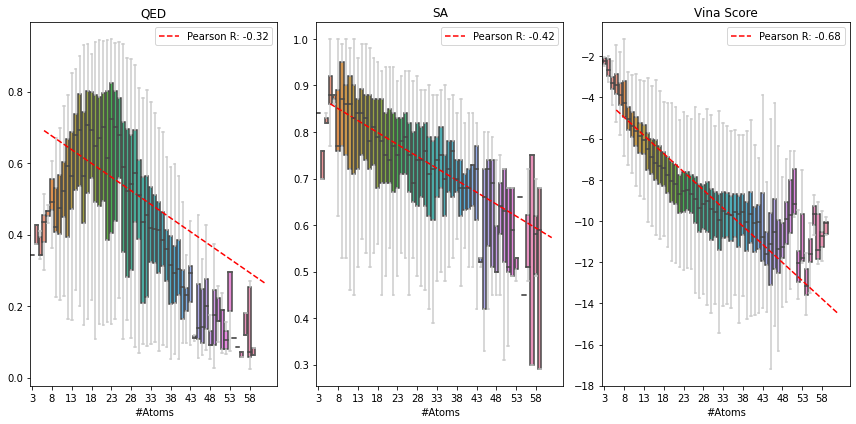

In [4]:
import pickle

data_stats = pickle.load(open('../stats.pkl', 'rb'))
data_stats = [item for item in data_stats if item['n_atoms'] < 60]

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr

# plot the properties w.r.t. n_atoms
# fit with a curve showing spearman correlation

data_stats = sorted(data_stats, key=lambda x: x['n_atoms'])
n_atoms = [x['n_atoms'] for x in data_stats]
qed = [x['qed'] for x in data_stats]
sa = [x['sa'] for x in data_stats]
affinity = [x['affinity'] for x in data_stats]

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.boxplot(x=n_atoms, y=qed, showfliers=False, capprops=dict(color='.8'), whiskerprops=dict(color='.8'),)
fit = np.polyfit(n_atoms, qed, 1)
fit_fn = np.poly1d(fit)
# plt.plot(n_atoms, fit_fn(n_atoms), color='red', label=f'Spearman R: {spearmanr(n_atoms, qed)[0]:.2f}', linestyle='--')
plt.plot(n_atoms, fit_fn(n_atoms), color='red', label=f'Pearson R: {np.corrcoef(n_atoms, qed)[0, 1]:.2f}', linestyle='--')
plt.title('QED')
plt.xlabel('#Atoms')
plt.ylabel('')
plt.xticks(np.arange(0, 60, 5))
plt.legend()

plt.subplot(1, 3, 2)
sns.boxplot(x=n_atoms, y=sa, showfliers=False, capprops=dict(color='.8'), whiskerprops=dict(color='.8'),)
fit = np.polyfit(n_atoms, sa, 1)
fit_fn = np.poly1d(fit)
# plt.plot(n_atoms, fit_fn(n_atoms), color='red', label=f'Spearman R: {spearmanr(n_atoms, sa)[0]:.2f}', linestyle='--')
plt.plot(n_atoms, fit_fn(n_atoms), color='red', label=f'Pearson R: {np.corrcoef(n_atoms, sa)[0, 1]:.2f}', linestyle='--')
plt.title('SA')
plt.xlabel('#Atoms')
plt.ylabel('')
plt.xticks(np.arange(0, 60, 5))
plt.legend()

plt.subplot(1, 3, 3)
# ignore the outlier
filtered_atoms, filtered_affinity = [], []
for n_atom, aff in zip(n_atoms, affinity):
    if aff < 0:
        filtered_atoms.append(n_atom)
        filtered_affinity.append(aff)
sns.boxplot(x=filtered_atoms, y=filtered_affinity, showfliers=False, capprops=dict(color='.8'), whiskerprops=dict(color='.8'),)
fit = np.polyfit(filtered_atoms, filtered_affinity, 1)
fit_fn = np.poly1d(fit)
# plt.plot(n_atoms, fit_fn(n_atoms), color='red', label=f'Spearman R: {spearmanr(n_atoms, affinity)[0]:.2f}', linestyle='--')
plt.plot(filtered_atoms, fit_fn(filtered_atoms), color='red', label=f'Pearson R: {np.corrcoef(filtered_atoms, filtered_affinity)[0, 1]:.2f}', linestyle='--')
plt.title('Vina Score')
plt.xlabel('#Atoms')
plt.xticks(np.arange(0, 60, 5))
plt.ylabel('')

plt.legend()
plt.tight_layout()
plt.savefig('stats.pdf', dpi=300)

<Figure size 864x1296 with 0 Axes>

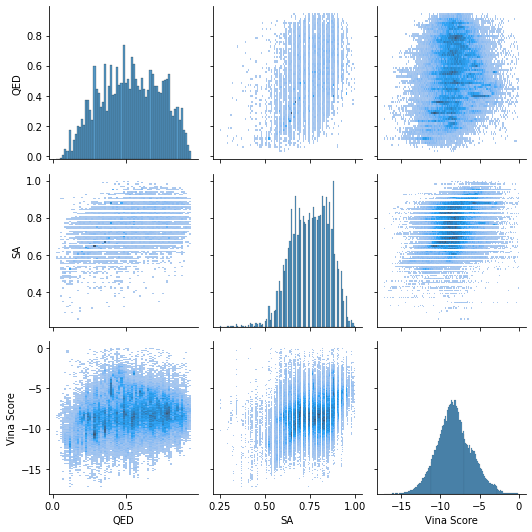

In [13]:
import pickle
import pandas as pd

data_stats = pickle.load(open('../stats.pkl', 'rb'))
data_stats = [item for item in data_stats if item['n_atoms'] < 60]

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr

# plot the properties w.r.t. each other
# fit with a curve showing spearman correlation

n_atoms = [x['n_atoms'] for x in data_stats]
qed = [x['qed'] for x in data_stats]
sa = [x['sa'] for x in data_stats]
affinity = [x['affinity'] for x in data_stats]

data_stats_filtered = [item for item in data_stats if item['affinity'] < 0]
filtered_qed = [x['qed'] for x in data_stats_filtered]
filtered_sa = [x['sa'] for x in data_stats_filtered]
filtered_affinity = [x['affinity'] for x in data_stats_filtered]

name2key = {
    'qed': 'QED',
    'sa': 'SA',
    'affinity': 'Vina Score',
    'affinity_unnormalized': 'Vina Score (Unnormalized)',
    'n_atoms': '#Atoms'
}
data_stats_filtered = [{name2key[k]: v for k, v in item.items()} for item in data_stats_filtered]
data_stats_filtered = pd.DataFrame(data_stats_filtered)

r_qed_sa = spearmanr(qed, sa)[0]
r_qed_affinity = spearmanr(filtered_qed, filtered_affinity)[0]
r_sa_affinity = spearmanr(filtered_sa, filtered_affinity)[0]

plt.figure(figsize=(12, 6*3))
sns.pairplot(data_stats_filtered, x_vars=['QED', 'SA', 'Vina Score'], y_vars=['QED', 'SA', 'Vina Score'], kind='hist')

plt.tight_layout()
plt.savefig('prop_correlation.pdf', dpi=300)

In [19]:
data_stats = pickle.load(open('../stats.pkl', 'rb'))
# data_stats = [item for item in data_stats if item['n_atoms'] < 60]
qed = [x['qed'] for x in data_stats]
sa = [x['sa'] for x in data_stats]
affinity = [x['affinity'] for x in data_stats]
r_qed_sa = spearmanr(qed, sa)[0]
r_qed_affinity = spearmanr(qed, affinity)[0]
r_sa_affinity = spearmanr(sa, affinity)[0]

print(f'QED vs SA: {r_qed_sa:.2f}')
print(f'QED vs Vina Score: {r_qed_affinity:.2f}')
print(f'SA vs Vina Score: {r_sa_affinity:.2f}')

QED vs SA: 0.41
QED vs Vina Score: 0.16
SA vs Vina Score: 0.33
